In [39]:
using DifferentialEquations
using StochasticDelayDiffEq
using SpecialFunctions
using Plots
using XLSX
using Turing
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW

In [3]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

# Define DataFrame object
data = DataFrame(
  year = Int[],
  open_magn_flux = Float64[],
  open_magn_flux_err = Float64[],
  ssa_open_magn_flux = Float64[],
  sunspots_num = Float64[],
  sunspots_err = Float64[],
  ssa_sunspots = Float64[]
)

# Open file and for each row write data into the DataFrame
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
  sheet = file["Data"] 

  for row in XLSX.eachrow(sheet)
    if isa(row[2], Number)
      push!(data, (
        year = row[2],
        open_magn_flux = row[3],
        open_magn_flux_err = row[4],
        ssa_open_magn_flux = row[5],
        sunspots_num = row[7],
        sunspots_err = row[8],
        ssa_sunspots = row[9]
      ))
    end
  end
end

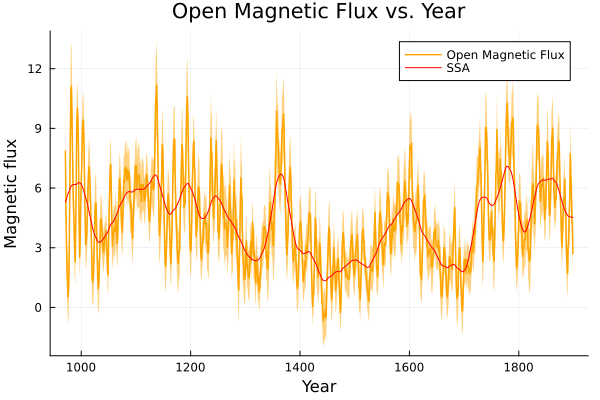

In [10]:
# PLOTTING OF THE OPEN MAGNETIC FLUX RECORDS FROM 971 TO 1899 (AD)

plot(data.year, data.open_magn_flux, ribbon = data.open_magn_flux_err, xlabel = "Year", ylabel = "Magnetic flux", 
    title = "Open Magnetic Flux vs. Year", label = "Open Magnetic Flux", linewidth = 1.5, color = "orange")
plot!(data.year, data.ssa_open_magn_flux, label = "SSA", linewidth = 1, color = "red")

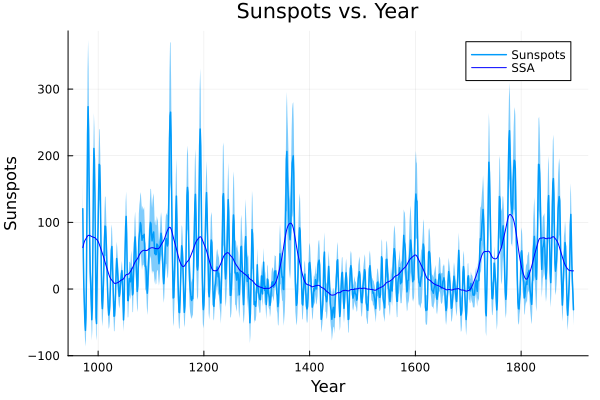

In [12]:
# PLOTTING OF THE SUNSPOT RECORDS FROM 971 TO 1899 (AD)

plot(data.year, data.sunspots_num, ribbon = data.sunspots_err, xlabel = "Year", ylabel = "Sunspots", 
    title = "Sunspots vs. Year", label = "Sunspots", linewidth = 1.5)
plot!(data.year, data.ssa_sunspots, label = "SSA", linewidth = 1, color = "blue")

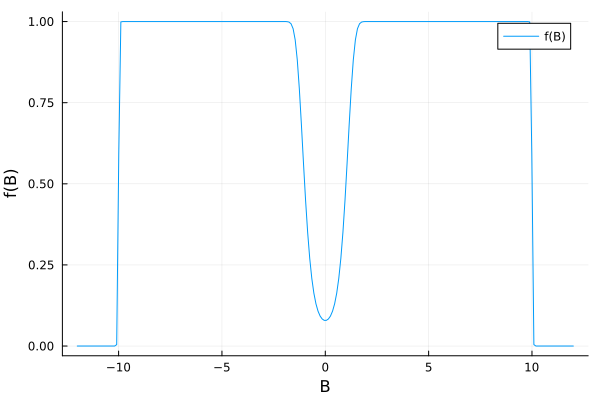

In [13]:
# BOX-SHAPED FUNCTION FOR THE MAGNETIC FIELD RANGE

# Define limits
B_min = 1
B_max = 10

# Define the function
function f(B)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Plot (range [-12, 12])
B_values = range(-12, stop = 12, length = 240)
f_values = f(B_values)
plot(B_values, f_values, xlabel = "B", ylabel = "f(B)", label = "f(B)")

##############################################################

# DIMENSION OF THE MAGNETIC FIELD???

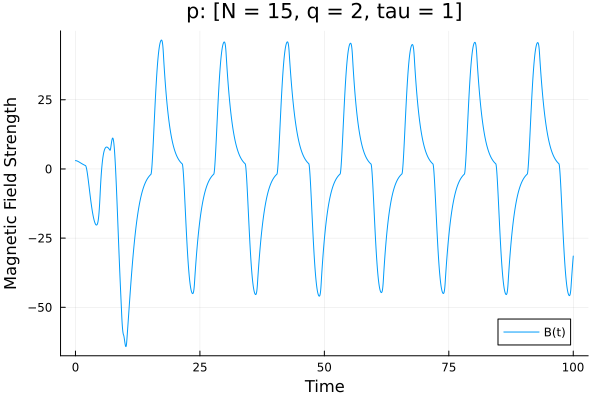

In [15]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define parameters
N = 15
T0 = 0.52
T1 = 0.3
tau = 1
q = (T0 + T1) / tau
q = 2
p = [N, q, tau]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 100)
h(p, t) = [0.0, 0.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

# Define and solve the DDE problem
prob = DDEProblem(MagneticField, B0, h, tspan, p)
sol = solve(prob, MethodOfSteps(Tsit5()), saveat = 0.01)

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, q = $q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

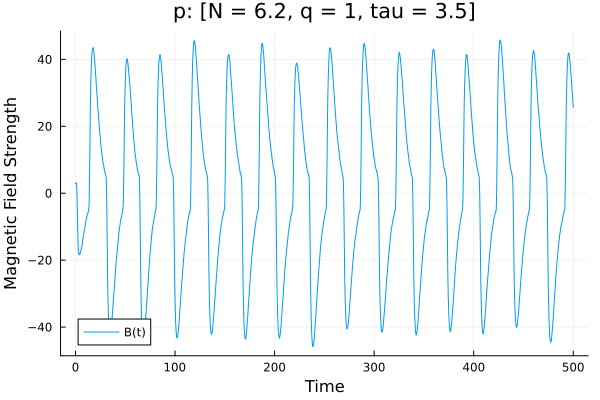

In [19]:
# SDDE PROBLEM WITHOUT PERIODIC MODULATION

# Define parameters
N = 6.2
T0 = 3
T1 = 0.1
tau = 3.5
T = T0 + T1
sigma = 0.04
B_max = 6.0

params = [N, T, tau, sigma, B_max]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 500)
h(p, t) = [0.0, 0.0]

# Define noise initial conditions
noise0 = [1.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  q = T / tau

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

function noise(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  du[1] = (sigma * Bmax)
end

# Define and solve the SDDE problem
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, params)
sol = solve(prob, EM(), dt = 0.01)

# Plot 
plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, q = $q, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

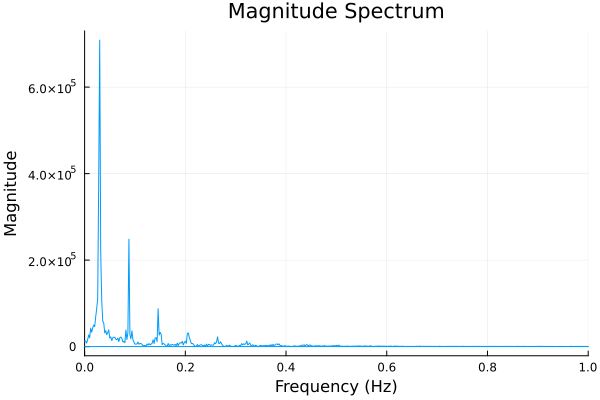

In [23]:
simulated_data = sol[1, :]
Y = fft(simulated_data)
Fs = 1 / ((sol.t[2] - sol.t[1]))
N = length(simulated_data)
freqs = fftfreq(N, Fs)

# Plot the magnitude spectrum
plot(freqs, abs.(Y), xlabel="Frequency (Hz)", ylabel="Magnitude", title="Magnitude Spectrum", legend=false, xlims =(0, 1))

In [30]:
params = [6.2, 3.1, 3.5, 0.04, 6.0]
tspan = (0.0, 500.0)
B0 = [1.0, 0.0]

prob = SDDEProblem(MagneticField, noise, B0, h, tspan, params)
sol = solve(prob, EM(), dt = 0.02)

observed_data = sol[1,:]
fourier_transform_obs = fft(observed_data)
fourier_indeces = sortperm(abs.(fourier_transform_obs), rev=true)[1:20]
fourier_obs = abs.(fourier_transform_obs[fourier_indeces])

prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

function f_dist(θ)
  prob = SDDEProblem(MagneticField, noise, B0, h, tspan, θ)
  sol = solve(prob, EM(), dt = 0.01)
  
  simulated_data = sol[1,:]

  fourier_transform = fft(simulated_data)
  fourier_stats = abs.(fourier_transform[fourier_indeces])

  rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
  
  return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=100, n_simulation=100000, v=1.0)

display(result)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 76.98105645032571 
[ Info: Population with 100 particles initialised.
[ Info: Initial ϵ = [1.2154554911492093, 0.5317204363053637, 1.264997813447333, 0.58435105394513, 0.5787396747346543, 2.263265704103192, 3.2372558377246414, 0.5503152681577081, 23032.712759849266, 0.6248427561693677, 0.7191991955549242, 2.0597155214764213, 41318.45535916644, 0.647263623947279, 1.3606645282212528, 0.6400022286243411, 4999.632532104799, 0.7954735449768909, 10183.703483049652, 0.6947482254358702]
[ Info: 2024-05-20T18:00:45.295 -- Starting population updates.
[ Info: Resampling 2 (δ = 0.1) - ESS = 76.38481827334185
┌ Info: 2024-05-20T18:04:48.743 -- Update 100 of 999 -- ETA: 00:36:28 
│  ϵ: [0.04137, 0.1691, 0.05205, 0.1733, 0.1909, 0.1903, 0.3221, 0.182, 0.2969, 0.1821, 0.1897, 0.1412, 0.1689, 0.1484, 0.1119, 0.1347, 0.08879, 0.1781, 0.05115, 0.1696] 
└  mean transformed distance: 0.2528 
[ Info: R

Approximate posterior sample with 100 particles:
  - simulations used: 100000
  - average transformed distance: 0.2365
  - ϵ: [0.007406, 0.1452, 0.01287, 0.1524, 0.161, 0.2635, 0.155, 0.1581, 0.1994, 0.1538, 0.1583, 0.007663, 0.02768, 0.1629, 0.1743, 0.1509, 0.01361, 0.1626, 0.02303, 0.1584]
  - population resampling: 16
  - acceptance rate: 0.03303
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 


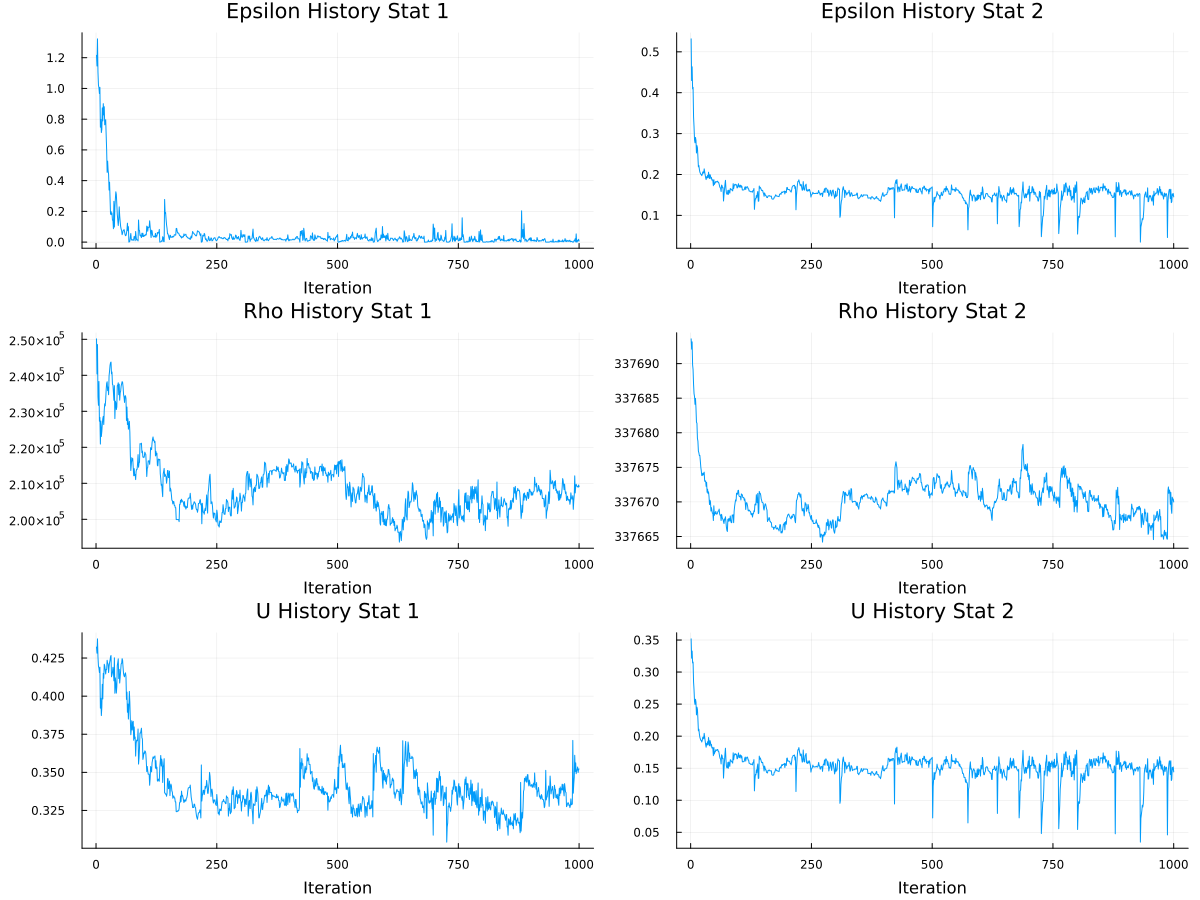

In [31]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [34]:
params = [6.2, 3.1, 3.5, 0.04, 6.0]
tspan = (0.0, 500.0)
B0 = [1.0, 0.0]

prob = SDDEProblem(MagneticField, noise, B0, h, tspan, params)
sol = solve(prob, EM(), dt = 0.01)

observed_data = sol[1,:]
fourier_transform_obs = fft(observed_data)
fourier_indeces = 1:6:120
fourier_obs = abs.(fourier_transform_obs[fourier_indeces])

prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

function f_dist(θ::Vector{Float64}; type::Int64 = 1)
  prob = SDDEProblem(MagneticField, noise, B0, h, tspan, θ)
  sol = solve(prob, EM(), dt = 0.01)
  
  simulated_data = sol[1,:]

  fourier_transform = fft(simulated_data)
  fourier_indeces = 1:6:120
  fourier_stats = abs.(fourier_transform[fourier_indeces])

  rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
  
  return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=1000, n_simulation=1000000, v=1.0, type = 1)

display(result)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 78.50761218935733 
[ Info: Population with 100 particles initialised.
[ Info: Initial ϵ = [1.2063569298557415, 0.8029202508492628, 1.4078476948059284, 2.518601126036566, 1.0855747958555584, 1.228421448396502, 0.7503854282952576, 1.4428171091366215, 0.8811852706318383, 0.8012543272292535, 0.5929467419836354, 0.6604755761217126, 12744.609717439344, 0.9369163890625922, 0.7373345153898567, 1.3768252498685636, 0.5704950235146294, 12344.867904910276, 0.9066732164863097, 1.515280607983048]
[ Info: 2024-05-20T18:53:42.959 -- Starting population updates.
[ Info: Resampling 2 (δ = 0.1) - ESS = 85.78563546774863
[ Info: Resampling 3 (δ = 0.1) - ESS = 81.3209761846312
┌ Info: 2024-05-20T18:59:48.180 -- Update 100 of 999 -- ETA: 00:54:43 
│  ϵ: [0.394, 0.2044, 0.3672, 0.3402, 0.2308, 0.2677, 0.1382, 0.09647, 0.2386, 0.3034, 0.2522, 0.2546, 0.04481, 0.2305, 0.2397, 0.1731, 0.2747, 0.06677, 0.224

Approximate posterior sample with 100 particles:
  - simulations used: 100000
  - average transformed distance: 0.1833
  - ϵ: [0.07665, 0.1348, 0.1288, 0.05607, 0.1368, 0.1209, 0.08284, 0.06706, 0.1719, 0.1698, 0.1864, 0.1815, 0.01583, 0.1686, 0.1821, 0.09129, 0.1812, 0.05067, 0.1777, 0.06828]
  - population resampling: 7
  - acceptance rate: 0.0147
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 


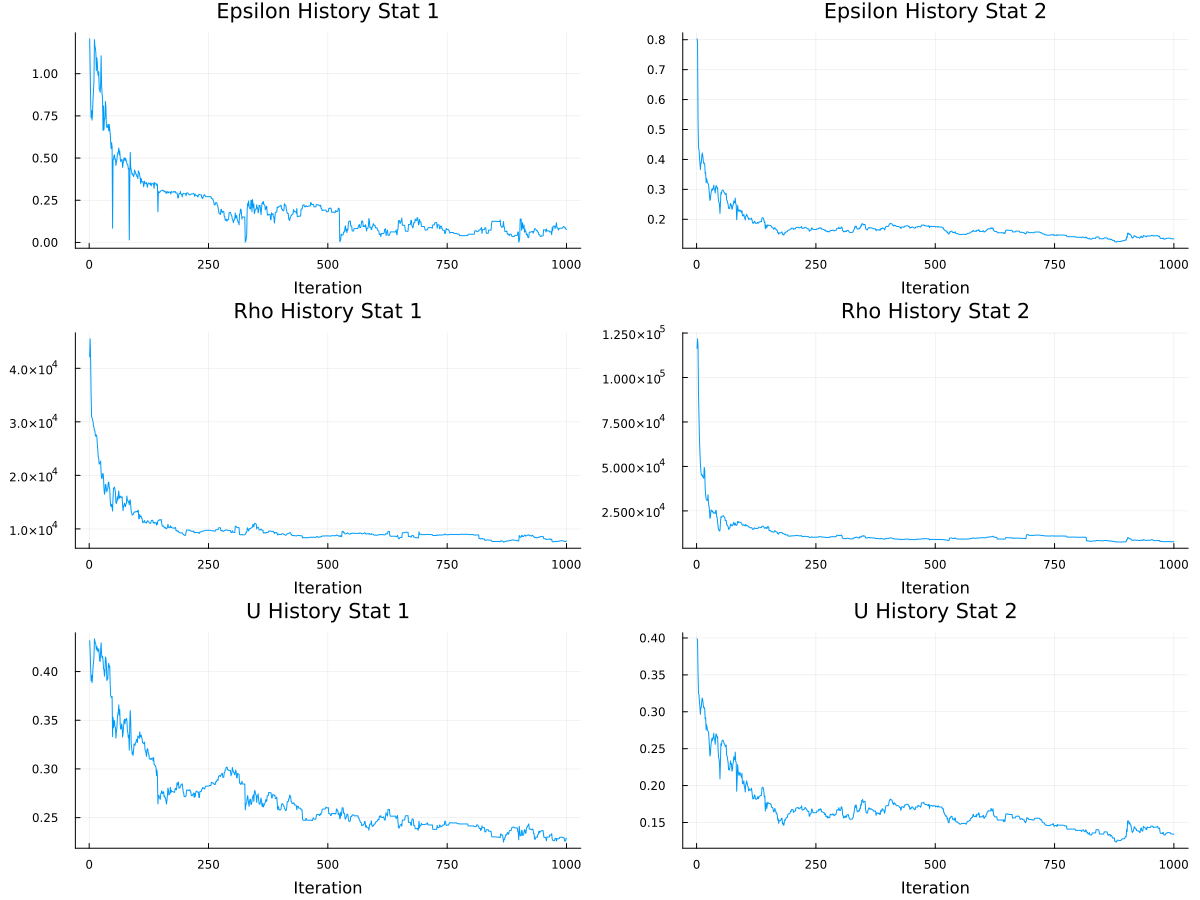

In [35]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

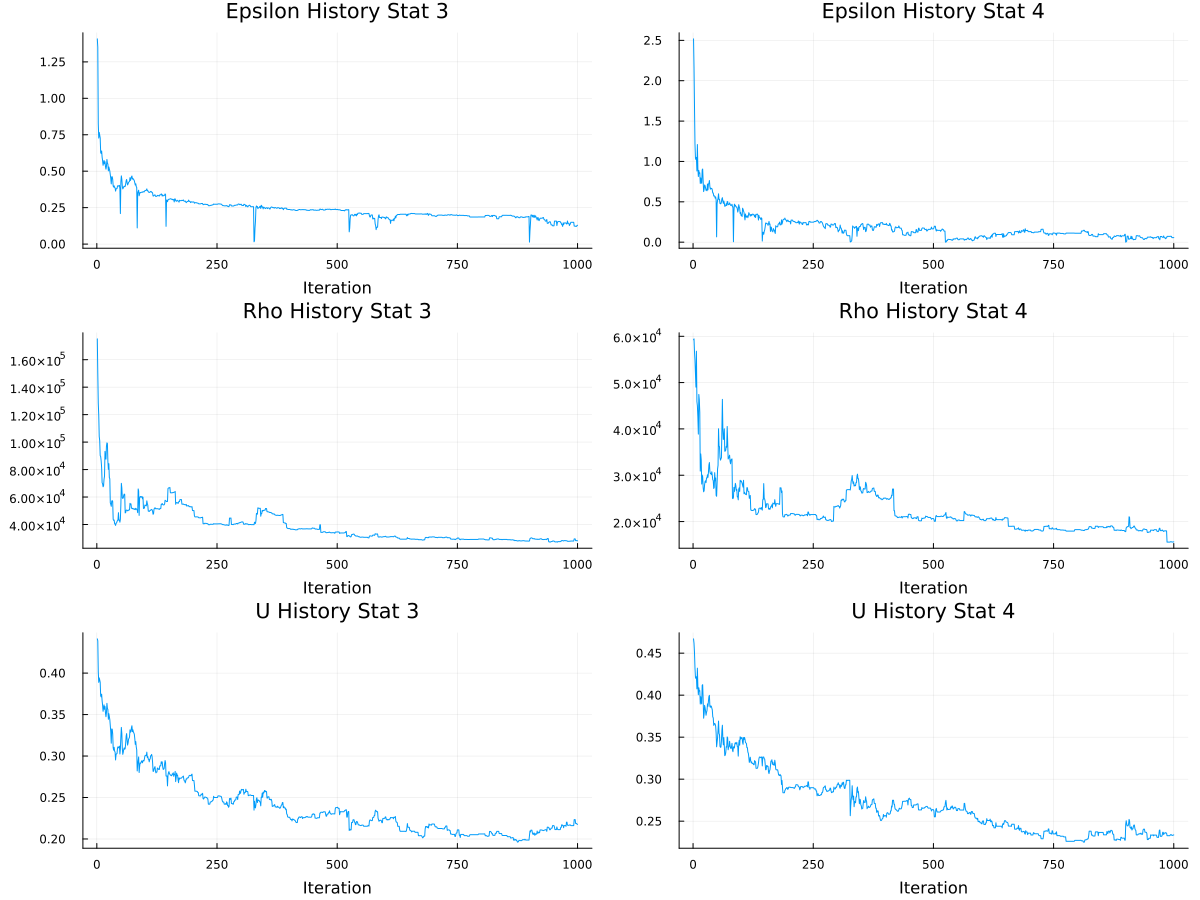

In [37]:
rho_stat3 = rho_singeps[3, :]
rho_stat4 = rho_singeps[4, :]

eps_stat3 = eps_singeps[3, :]
eps_stat4 = eps_singeps[4, :]

u_stat3 = u_singeps[3, :]
u_stat4 = u_singeps[4, :]

p1 = plot(eps_stat3, title="Epsilon History Stat 3", xlabel="Iteration", legend=false)
p2 = plot(eps_stat4, title="Epsilon History Stat 4", xlabel="Iteration", legend=false)
p3 = plot(rho_stat3, title="Rho History Stat 3", xlabel="Iteration", legend=false)
p4 = plot(rho_stat4, title="Rho History Stat 4", xlabel="Iteration", legend=false)
p5 = plot(u_stat3, title="U History Stat 3", xlabel="Iteration", legend=false)
p6 = plot(u_stat4, title="U History Stat 4", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [40]:
# ANALYSIS WITH SYNTETIC DATA
p = [6.2, 3.1, 3.5, 0.04, 6.0]  # Parameters N, T, tau, sigma, Bmax
tspan = (0.0, 10.0)
u0 = [1.0, 0.0]  # Initial condition: [B, dB]

# Create a DDEProblem object
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, p)
# Solve the DDE using a suitable method
sol = solve(prob, EM(), dt = 0.01)
# Generate observational data
observed_data = sol[1, :]  # Add noise
fourier_transform_obs = fft(observed_data)
fourier_range_obs = 1:6:120
fourier_obs = abs.(fourier_transform_obs[fourier_range_obs])

# Define prior distributions for the parameters
prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

# Define a function to simulate data and calculate distance
function f_dist(x::Vector{Float64}; type::Int64 = 1)
    sol = solve(SDDEProblem(MagneticField, noise, B0, h, tspan, x), EM(), dt = 0.01)
    simulated_data = sol[1, :]

    # Perform Fourier transform
    fourier_transform = fft(simulated_data)
    fourier_range = 1:6:120
    fourier_stats = abs.(fourier_transform[fourier_range])

    rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
    
    return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=1000, n_simulation=1000000, v=1.0, type=1)
println("Estimated parameters: ", result)

[ Info: Using threads: 1 
[ Info: Initializing population...
[ Info: Initial resampling (δ = 0.1) - ESS = 557.1509353130243 
[ Info: Population with 1000 particles initialised.
[ Info: Initial ϵ = [0.6967255188610462, 0.35768007847879885, 0.3366893290924509, 0.31448152823299735, 0.3146124931780526, 0.3146106481367407, 0.3116699926677818, 0.3160241438831892, 0.31450550272666844, 0.32308874815367483, 0.32184079752840916, 0.3258919868871915, 0.32845529018887654, 0.31572747809788226, 0.31199486763648515, 0.33223898766592475, 0.3248338297284501, 0.3287455809673934, 0.31997074287782, 0.32901863560457656]
[ Info: 2024-05-21T11:45:00.513 -- Starting population updates.
┌ Info: 2024-05-21T11:46:28.791 -- Update 100 of 999 -- ETA: 00:13:13 
│  ϵ: [0.008034, 0.01594, 0.0296, 0.059, 0.05693, 0.0816, 0.06818, 0.07597, 0.05514, 0.07833, 0.07903, 0.08023, 0.07006, 0.07088, 0.0451, 0.03906, 0.03492, 0.08023, 0.04638, 0.06708] 
└  mean transformed distance: 0.09814 
[ Info: Resampling 2 (δ = 0.1) - ESS

Estimated parameters: Approximate posterior sample with 1000 particles:
  - simulations used: 1000000
  - average transformed distance: 0.03955
  - ϵ: [7.578e-7, 7.922e-7, 8.552e-7, 2.88e-6, 2.734e-5, 5.347e-5, 5.647e-6, 6.711e-6, 1.145e-5, 9.784e-5, 1.363e-5, 0.0001033, 1.831e-5, 2.156e-5, 1.633e-6, 2.754e-6, 2.708e-6, 8.306e-6, 3.934e-6, 2.031e-6]
  - population resampling: 3
  - acceptance rate: 0.006474
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 



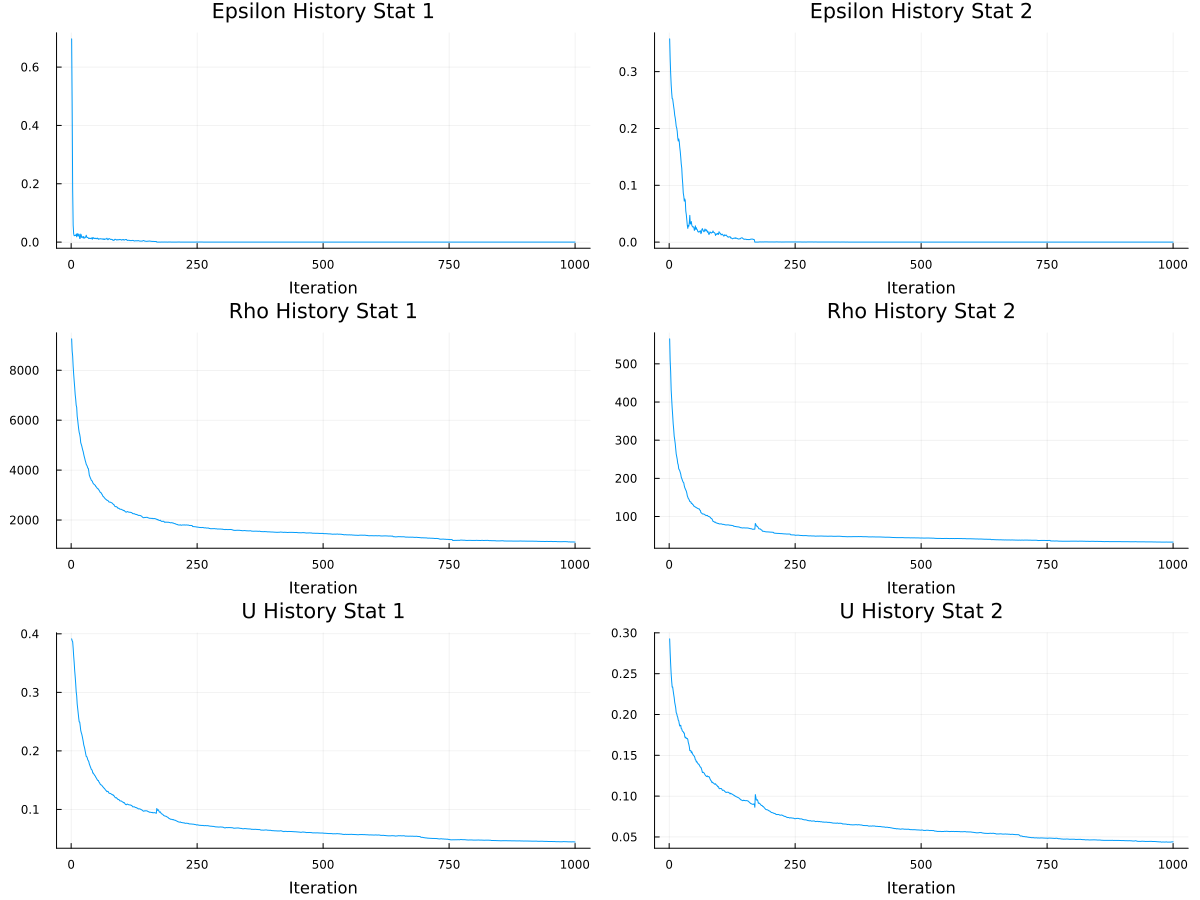

In [41]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)